In [21]:
import networkx as nx
import fast_model_improved as fmi
from pyexpat import model
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy

In [22]:
def choose_influencers(model, num_influencers, method='random'):
    if method == 'random':
        return model.random_influencers(num_influencers)
    elif method == 'hill_climbing':
        return model.greedy_hill_climbing(num_influencers, steps=10, R=10)
    else:
        raise ValueError("Unsupported method for selecting influencers")

def run_influence_cascade(graph, num_influencers, steps, selection_method='random'):

    # Initialize the model
    model = fmi.InfluenceDeinfluenceModel(graph, selection_method)
    
    # Choose influencers
    influencers = choose_influencers(model, num_influencers, method=selection_method)
    model.set_influencers(influencers)
    model.selected_influencers = influencers
    
    # Run the cascade
    model.run_cascade(steps)
    
    # Return the updated graph and model
    return model

def run_simple_cascade(steps):
    model.set_influencers(model.selected_influencers)
    model.run_cascade(steps)
    return model


In [23]:
def select_deinfluencers(k_deinfluencers_ls):
    deinfluencers_list = []
    
    for k in k_deinfluencers_ls:
        deinfluencers_dict = {}
        
        # Sample function calls to model object methods
        deinfluencers_dict['Random'] = model.select_deinfluencers_random(k)
        deinfluencers_dict['RanExIniInf'] = model.select_deinfluencers_from_not_ini_influencers(k)
        deinfluencers_dict['RanExAllInf'] = model.select_deinfluencers_from_not_influencers(k)
        deinfluencers_dict['Degree'] = model.select_deinfluencers_degree_centrality(k)
        deinfluencers_dict['Closeness'] = model.select_deinfluencers_closeness_centrality(k)
        deinfluencers_dict['Betweenness'] = model.select_deinfluencers_betweenness_centrality(k)
        deinfluencers_dict['Eigenvector'] = model.select_deinfluencers_eigenvector_centrality(k, max_iter=1000, tol=1e-06)
        deinfluencers_dict['PageRank'] = model.select_deinfluencers_pagerank_centrality(k)
        deinfluencers_dict['RIniInf'] = model.select_deinfluencers_from_ini_influencers(k)
        deinfluencers_dict['RInfl'] = model.select_deinfluencers_from_influencers(k)
        deinfluencers_dict['RRankedIniInf'] = model.select_deinfluencers_from_ini_influencers_degree_centrality(k)
        deinfluencers_dict['RRankedInf'] = model.select_deinfluencers_from_influencers_degree_centrality(k)
        
        deinfluencers_list.append((k, deinfluencers_dict))
    
    return deinfluencers_list

# Define the combined count function
def count_deinfluenced(model, deinfluencers, num_runs, steps):
    total_deinfluenced = 0
    total_influenced = 0
    total_transition_counts = {'I->S': 0, 'D->S': 0, 'D->I': 0}
    
    # Create a deep copy of the model to ensure initial influencers remain the same
    initial_model = copy.deepcopy(model)
    
    for _ in range(num_runs):
        # Reset the model to the initial state with the same influencers
        model = copy.deepcopy(initial_model)
        model.reset_transition_counts()
        model.set_deinfluencers(deinfluencers)
        model.run_cascade(steps)
        
        total_deinfluenced += model.evaluate_deinfluence()
        total_influenced += model.evaluate_influence()
        
        for key in total_transition_counts:
            total_transition_counts[key] += model.transition_counts[key]
            
    return total_deinfluenced / num_runs, total_influenced / num_runs, {key: total / num_runs for key, total in total_transition_counts.items()}

def average_results(deinfluencers_list, model, num_runs, steps):
    cumulative_results = {}

    for k, deinfluencers_methods in deinfluencers_list:
        if k not in cumulative_results:
            cumulative_results[k] = {method: (0, 0, {'I->S': 0, 'D->S': 0, 'D->I': 0}) for method in deinfluencers_methods.keys()}
        
        for _ in range(num_runs):
            results = {
                method: count_deinfluenced(model, deinfluencers, num_runs, steps)
                for method, deinfluencers in deinfluencers_methods.items()
            }
            
            for method, result in results.items():
                cumulative_results[k][method] = (
                    cumulative_results[k][method][0] + result[0],
                    cumulative_results[k][method][1] + result[1],
                    {key: cumulative_results[k][method][2][key] + result[2][key] for key in result[2]}
                )
    
    average_results = {
        k: {
            method: (
                cumulative_results[k][method][0] / num_runs,
                cumulative_results[k][method][1] / num_runs,
                {key: cumulative_results[k][method][2][key] / num_runs for key in cumulative_results[k][method][2]}
            )
            for method in cumulative_results[k]
        }
        for k in cumulative_results
    }
    
    return average_results


In [24]:
G = nx.erdos_renyi_graph(2000, 0.005, seed=42)
model = run_influence_cascade(G, num_influencers=50, steps=3, selection_method='random')

# Evaluate the influence and deinfluence
num_influenced = model.evaluate_influence()
num_deinfluenced = model.evaluate_deinfluence()
num_susceptible = model.evaluate_susceptible()

# Create a deep copy of the model
model_fixed_influencers = copy.deepcopy(model)

In [25]:
# Evaluate the influence and deinfluence
num_influenced = model_fixed_influencers.evaluate_influence()
num_deinfluenced = model_fixed_influencers.evaluate_deinfluence()
num_susceptible = model_fixed_influencers.evaluate_susceptible()

print(f"Number of influenced nodes: {num_influenced}")
print(f"Number of deinfluenced nodes: {num_deinfluenced}")
print(f"Number of susceptible nodes: {num_susceptible}")
print('influencer', model.selected_influencers)


Number of influenced nodes: 1902
Number of deinfluenced nodes: 0
Number of susceptible nodes: 98
influencer {1411, 1286, 776, 524, 1933, 1423, 660, 534, 666, 1690, 542, 800, 164, 676, 550, 1703, 815, 305, 565, 1333, 695, 1208, 1466, 1346, 1986, 1988, 1222, 1991, 1485, 1871, 1232, 212, 1237, 1626, 1499, 1122, 226, 740, 357, 1766, 486, 1000, 997, 1258, 245, 504, 1147, 1789, 254, 1663}


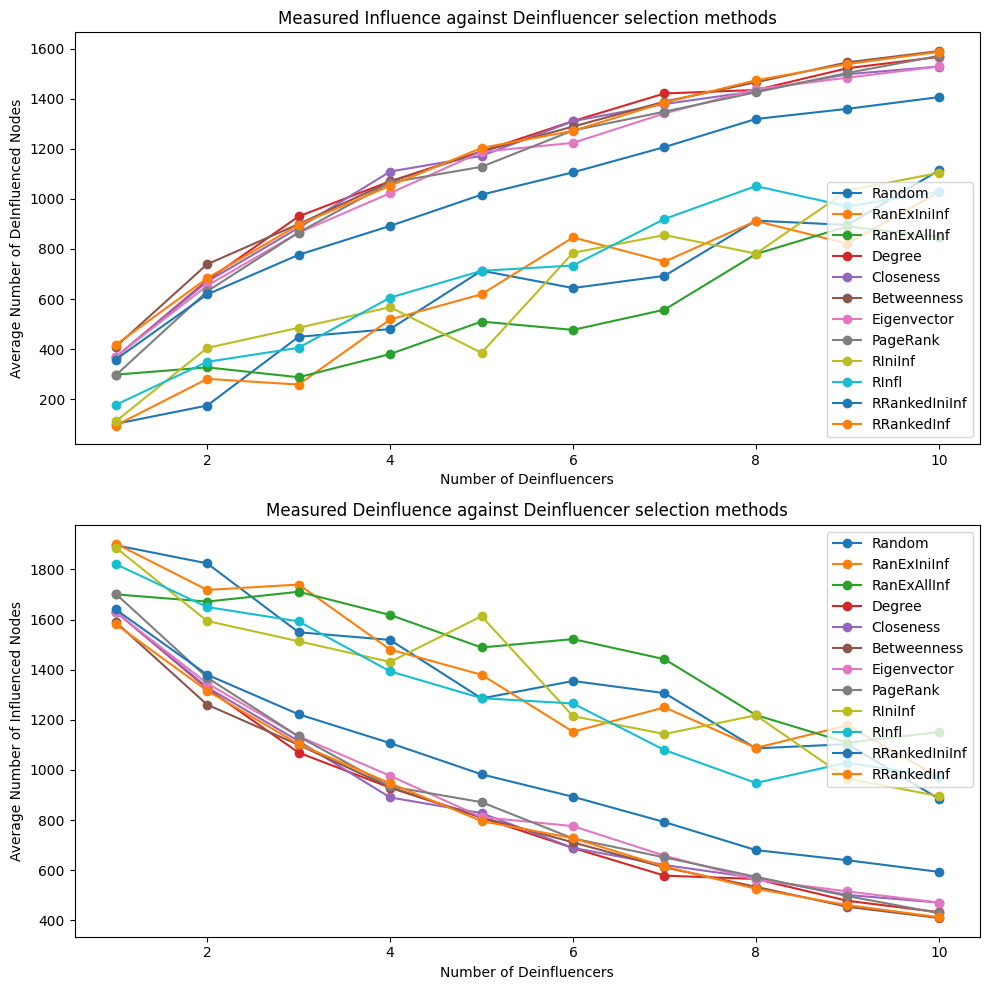

In [26]:
# Run simulation for different values of k
k_deinfluencers_ls = [1,2,3,4,5,6,7,8,9,10]  # Different values of k to test
deinfluencers_list = select_deinfluencers(k_deinfluencers_ls)
results = average_results(deinfluencers_list, model_fixed_influencers, num_runs=3, steps=3)

# Plotting results
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].set_title('Measured Influence against Deinfluencer selection methods')
axs[1].set_title('Measured Deinfluence against Deinfluencer selection methods')

# Create line plots
methods = results[next(iter(results))].keys()  # Get all methods from the first key
k_values = sorted(results.keys())  # Sort k values for plotting

for method in methods:
    influenced_nodes = [results[k][method][0] for k in k_values]
    total_steps = [results[k][method][1] for k in k_values]

    axs[0].plot(k_values, influenced_nodes, label=method, marker='o')
    axs[1].plot(k_values, total_steps, label=method, marker='o')

axs[0].legend()
axs[0].set_xlabel('Number of Deinfluencers')
axs[0].set_ylabel('Average Number of DeInfluenced Nodes')

axs[1].legend()
axs[1].set_xlabel('Number of Deinfluencers')
axs[1].set_ylabel('Average Number of Influenced Nodes')

plt.tight_layout()
plt.show()
